In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
src_path = os.path.join(os.getcwd(), "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

from src.utils import Utils
from src.fastbdt import FastBDT_binary_classification

# FastBDT

--- FastBDT Binary Classification ---

Data distribution:
is_signal
1    35765
0    34841
Name: count, dtype: int64

Using 59 features for training.

Training set size: 49424
Testing set size:  21182

Training the FastBDT model...
Training complete!

Model Accuracy on Test Set: 0.8567
Area Under ROC Curve (AUC): 0.9326

Generating ROC curve plot...
Plot saved as 'plots/fastbdt_roc_curve.png'


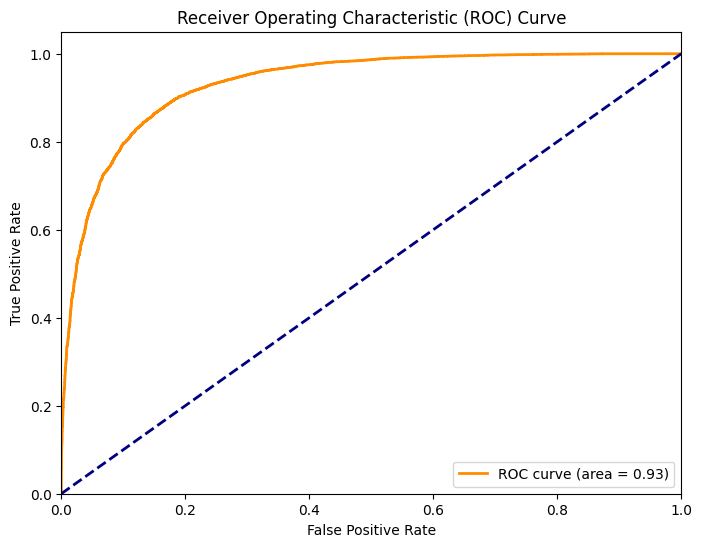


Intern Feature Importance:
{0: 0.7017221581942237, 1: 0.03450850384102836, 2: 0.0008233361239990838, 3: 0.0012153489520984394, 4: 0.008187593904258023, 5: 0.020221784282594836, 6: 0.018977015841959856, 7: 0.053126208407700146, 8: 0.016351954463351814, 9: 0.0022888874266576704, 10: 0.001191177978731517, 11: 0.0001482944863539958, 12: 0.00016632780062211032, 13: 0.0005760983770321998, 14: 0.0023385324356950763, 15: 0.0003701232214116885, 16: 0.013760092040739861, 17: 0.0003004891517140182, 18: 0.0015195576654253259, 19: 0.00034890064959515856, 20: 0.0006834711382758604, 21: 0.0002772291484011463, 22: 0.000629878698570229, 23: 0.000175845387709052, 24: 6.81165939549166e-05, 25: 0.0, 26: 0.00568844486696243, 27: 0.002102568601633334, 28: 0.0, 29: 0.01423933334007291, 30: 0.0020800018976544995, 31: 0.0, 32: 0.009764750455424237, 33: 0.0015635388208380366, 34: 0.00025266915728286866, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.005101065443814429, 40: 0.0010649797653314377, 41: 0.0050276297524

In [5]:
FastBDT_binary_classification(
    df=Utils.data_import("data/data_hep - data_hep.csv"),
    
)